In [1]:
import kaggle 

In [2]:
import os, glob, shutil
import urllib.request as r

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "rice_leaf_disease", "lentils"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        full_path = f"{saqlash_uchun_papka}/{data_nomi}"
        ds_nomi = url.split("/")[-1]
        os.makedirs(f"{saqlash_uchun_papka}/{ds_nomi}", exist_ok = True)
        
        print("Datani yuklash boshlanmoqda...")

        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "project1", data_nomi = "lentils")

Dataset yuklab olingan. project1/lentils papkasini ni tekshiring.


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from glob import glob
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root, transformations = None):
        super().__init__()
        
        self.root = glob(f"{root}/*.png")
        #print(len(self.root))
        self.transformations = transformations
        self.klass_nomlari = {}    
        klass_qiymati = 0
        
        for idx, yulak in enumerate(self.root):
            klass_nomi = self.klasses(yulak)
            if klass_nomi not in self.klass_nomlari: self.klass_nomlari[klass_nomi] = klass_qiymati; klass_qiymati += 1
        
                
            
    def __len__(self): return len(self.root)

    def klasses(self, yulak): return os.path.basename(yulak).split("_")[0]

    def __getitem__(self, idx):
        rasm_yulagi = self.root[idx]
        rasm = Image.open(rasm_yulagi).convert('RGB')
        javob = self.klass_nomlari[self.klasses(rasm_yulagi)]
        if self.transformations: rasm = self.transformations(rasm)
        
        return rasm, javob
            
transform = T.Compose([T.Resize((224,224)), T.ToTensor()])        
root = "../Downloads/project1/lentils-classification-dataset/data" 
model = CustomDataset(root = root, transformations = transform)
klass_nomlari = model.klass_nomlari
print(klass_nomlari)
model[100][0].shape

{'skinned': 0, 'split': 1, 'whole': 2}


torch.Size([3, 224, 224])

In [4]:
from torch.utils.data import DataLoader, random_split, Dataset

tr_length = len(model)
tr_len = int(tr_length * 0.9)
val_len = int(tr_length * 0.05)
ts_len = tr_length - tr_len - val_len

tr_ds, val_ds, ts_ds = random_split(model, [tr_len, val_len, ts_len])
print(f"Train datasetda {len(tr_ds)} ta data bor")
print(f"Validation datasetda {len(val_ds)} ta data bor")
print(f"Test datasetda {len(ts_ds)} ta data bor")

Train datasetda 267 ta data bor
Validation datasetda 14 ta data bor
Test datasetda 16 ta data bor


In [5]:
bs = 8
tr_dl = DataLoader(dataset = tr_ds, batch_size=bs, shuffle=True, num_workers=0)
val_dl = DataLoader(dataset = val_ds, batch_size=bs, shuffle=False, num_workers=0)
test_dl = DataLoader(dataset = ts_ds, batch_size=bs, shuffle=False, num_workers=0)
print(len(tr_dl))
print(len(val_dl))
print(len(test_dl))

34
2
2


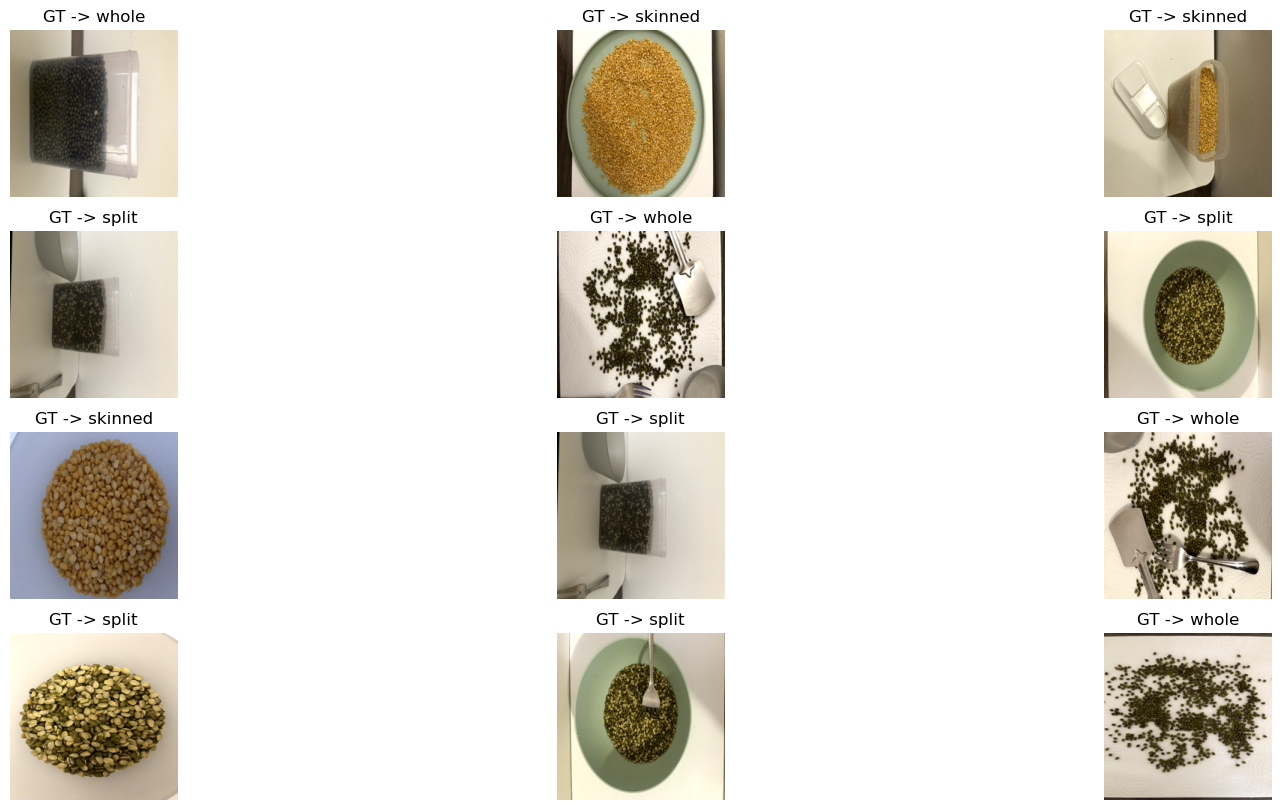

In [6]:
from matplotlib import pyplot as plt
import random
klass_nomlari = ["skinned", "split", "whole"]

def visualize(data, rasmlar_soni, qatorlar, klass_nomlari = None):

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(rasmlar_soni)]
    inversion_tfs = T.Compose([T.Normalize(mean = [0.], std = [1/0.4]), T.Normalize(mean = [-0.1], std = [1])])

    for idx, indeks in enumerate(indekslar):

        rasm, javob = data[indeks]
        plt.subplot(qatorlar, rasmlar_soni // qatorlar, idx + 1)
        # print(torch.unique(rasm))
        plt.imshow(inversion_tfs(rasm).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.imshow(((rasm)*255).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.axis("off")
        if klass_nomlari: plt.title(f"GT -> {klass_nomlari[javob]}")
        else: plt.title(f"GT -> {javob}")

visualize(data = tr_dl.dataset, rasmlar_soni = 12, qatorlar = 4, klass_nomlari = klass_nomlari)

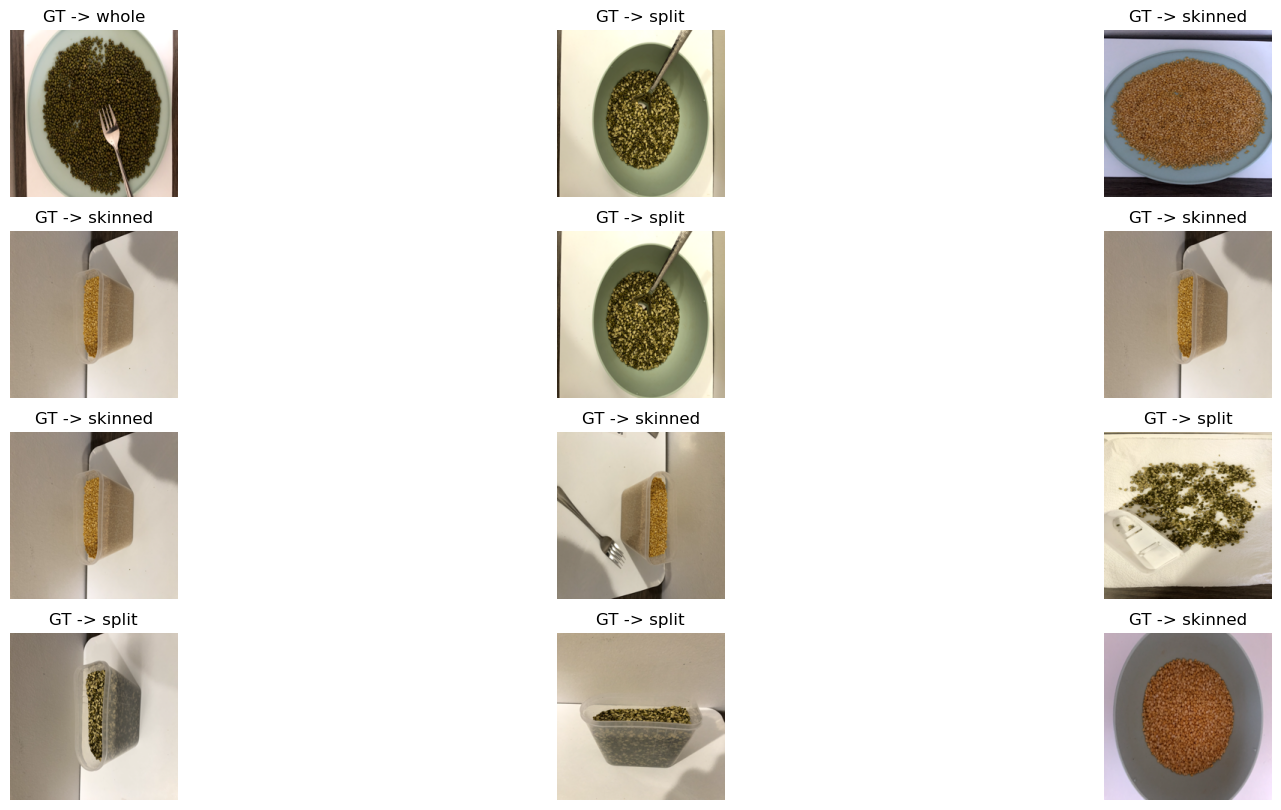

In [7]:
from matplotlib import pyplot as plt
import random
klass_nomlari = ["skinned", "split", "whole"]

def visualize(data, rasmlar_soni, qatorlar, klass_nomlari = None):

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(rasmlar_soni)]
    inversion_tfs = T.Compose([T.Normalize(mean = [0.], std = [1/0.4]), T.Normalize(mean = [-0.1], std = [1])])

    for idx, indeks in enumerate(indekslar):

        rasm, javob = data[indeks]
        plt.subplot(qatorlar, rasmlar_soni // qatorlar, idx + 1)
        # print(torch.unique(rasm))
        plt.imshow(inversion_tfs(rasm).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.imshow(((rasm)*255).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.axis("off")
        if klass_nomlari: plt.title(f"GT -> {klass_nomlari[javob]}")
        else: plt.title(f"GT -> {javob}")

visualize(data = val_dl.dataset, rasmlar_soni = 12, qatorlar = 4, klass_nomlari = klass_nomlari)

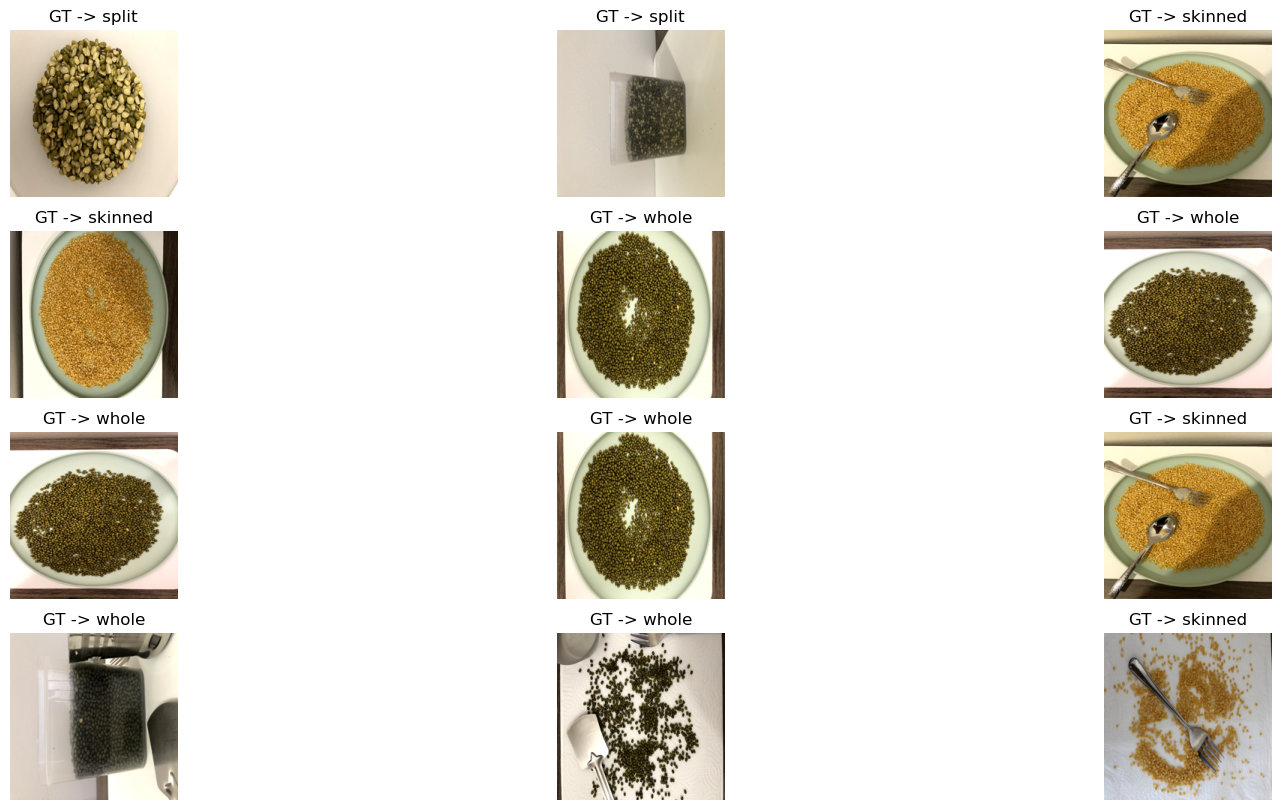

In [8]:
from matplotlib import pyplot as plt
import random
klass_nomlari = ["skinned", "split", "whole"]

def visualize(data, rasmlar_soni, qatorlar, klass_nomlari = None):

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(rasmlar_soni)]
    inversion_tfs = T.Compose([T.Normalize(mean = [0.], std = [1/0.4]), T.Normalize(mean = [-0.1], std = [1])])

    for idx, indeks in enumerate(indekslar):

        rasm, javob = data[indeks]
        plt.subplot(qatorlar, rasmlar_soni // qatorlar, idx + 1)
        # print(torch.unique(rasm))
        plt.imshow(inversion_tfs(rasm).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.imshow(((rasm)*255).cpu().permute(1,2,0).numpy().astype("uint8"), cmap = "gray")
        plt.axis("off")
        if klass_nomlari: plt.title(f"GT -> {klass_nomlari[javob]}")
        else: plt.title(f"GT -> {javob}")

visualize(data = test_dl.dataset, rasmlar_soni = 12, qatorlar = 4, klass_nomlari = klass_nomlari)

In [9]:
import timm

model = timm.create_model('resnet34', pretrained = True, num_classes = 3)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [22]:
epochs = 15
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
loss_fc = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params = model.parameters(), lr = 1e-3)

In [23]:
!pip install tqdm

In [24]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, epochs, device, loss_fc, opt, save_prefix):
  tr_acc_sc_ = []
  val_acc_sc_, val_epoc_loss_ = [],[]
  tr_total =0
  best_loss = np.inf
  decrease, not_improve, early_stop_threshold= 1,0,5

  print("Train is starting .....")

  for epoc in range(epochs):
      print(f"{epoc+1}- epoc is starting..")
      count=0
      tr_acc_sr, tr_total =0,0

      for idx, batch in tqdm(enumerate(tr_dl)):
          ims, gts = batch
          ims = ims.to(device)
          gts = gts.to(device)

          pred = model(ims)
          loss = loss_fc(pred, gts)

          tr_total+=ims.shape[0]
          pred_class = torch.argmax(pred, dim =1)
          count+=1
          tr_acc_sr+= (pred_class==gts).sum().item()

          optimazer.zero_grad()
          loss.backward()
          optimazer.step()

      model.eval()
      with torch.no_grad():
          val_acc_sc = 0
          val_total =0
          val_epoc_loss = 0

          for idx, batch in enumerate(val_dl):
              ims, gts = batch
              ims, gts = ims.to(device), gts.to(device)

              val_total+=ims.shape[0]

              pred = model(ims)


              pred_class = torch.argmax(pred, dim=1)
              val_acc_sc+=(pred_class==gts).sum().item()
              loss = loss_fc(pred, gts)
              val_epoc_loss+=loss.item()

              tr_ACC_SR = tr_acc_sr/tr_total
              VAL_acc_sc = val_acc_sc/val_total
              VAL_epoc_loss = val_epoc_loss/len(val_dl)


          print(f"{epoc+1} is finished..")
          print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
          print(f"{epoc+1} - epoc result:\n")
          print(f"{epoc+1}- epoc Train Accurancy score        -> {tr_ACC_SR:.3f}")
          print(f"{epoc+1}- epoc Validation Accurancy score   -> {VAL_acc_sc:.3f}")
          print(f"{epoc+1}- epoc Validation loss score        -> {VAL_epoc_loss:.3f}\n\n")


          tr_acc_sc_.append(tr_ACC_SR)
          val_acc_sc_.append(VAL_acc_sc)
          val_epoc_loss_.append(VAL_epoc_loss)

          # print(type(best_loss))

          if VAL_epoc_loss < best_loss:
              os.makedirs("best_model", exist_ok=True)
              best_loss = VAL_epoc_loss
              torch.save(model, f"best_model/{save_prefix}_best_model.pth")

  return {"tr_acc_sc": tr_acc_sc_, "val_acc_sc": val_acc_sc_, "val_epoc_loss": val_epoc_loss_}

In [25]:
result = train(model=model, tr_dl=tr_dl, val_dl=val_dl, epochs=15, device=device,
               loss_fc=loss_fc, opt=optimazer, save_prefix="lentils")

Train is starting .....
1- epoc is starting..


34it [00:01, 22.72it/s]


1 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 - epoc result:

1- epoc Train Accurancy score        -> 0.742
1- epoc Validation Accurancy score   -> 0.857
1- epoc Validation loss score        -> 0.426


2- epoc is starting..


34it [00:01, 27.47it/s]


2 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 - epoc result:

2- epoc Train Accurancy score        -> 0.820
2- epoc Validation Accurancy score   -> 0.786
2- epoc Validation loss score        -> 0.333


3- epoc is starting..


34it [00:01, 27.12it/s]


3 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 - epoc result:

3- epoc Train Accurancy score        -> 0.873
3- epoc Validation Accurancy score   -> 0.929
3- epoc Validation loss score        -> 0.206


4- epoc is starting..


34it [00:01, 27.35it/s]


4 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 - epoc result:

4- epoc Train Accurancy score        -> 0.895
4- epoc Validation Accurancy score   -> 0.786
4- epoc Validation loss score        -> 0.597


5- epoc is starting..


34it [00:01, 27.38it/s]


5 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 - epoc result:

5- epoc Train Accurancy score        -> 0.933
5- epoc Validation Accurancy score   -> 0.929
5- epoc Validation loss score        -> 0.222


6- epoc is starting..


34it [00:01, 27.46it/s]


6 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6 - epoc result:

6- epoc Train Accurancy score        -> 0.873
6- epoc Validation Accurancy score   -> 0.714
6- epoc Validation loss score        -> 0.418


7- epoc is starting..


34it [00:01, 26.78it/s]


7 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
7 - epoc result:

7- epoc Train Accurancy score        -> 0.865
7- epoc Validation Accurancy score   -> 1.000
7- epoc Validation loss score        -> 0.170


8- epoc is starting..


34it [00:01, 27.32it/s]


8 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
8 - epoc result:

8- epoc Train Accurancy score        -> 0.940
8- epoc Validation Accurancy score   -> 0.929
8- epoc Validation loss score        -> 0.365


9- epoc is starting..


34it [00:01, 27.23it/s]


9 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
9 - epoc result:

9- epoc Train Accurancy score        -> 0.970
9- epoc Validation Accurancy score   -> 0.929
9- epoc Validation loss score        -> 0.445


10- epoc is starting..


34it [00:01, 27.52it/s]


10 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
10 - epoc result:

10- epoc Train Accurancy score        -> 0.903
10- epoc Validation Accurancy score   -> 0.929
10- epoc Validation loss score        -> 0.095


11- epoc is starting..


34it [00:01, 27.34it/s]


11 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
11 - epoc result:

11- epoc Train Accurancy score        -> 0.895
11- epoc Validation Accurancy score   -> 1.000
11- epoc Validation loss score        -> 0.120


12- epoc is starting..


34it [00:01, 27.74it/s]


12 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
12 - epoc result:

12- epoc Train Accurancy score        -> 0.963
12- epoc Validation Accurancy score   -> 0.929
12- epoc Validation loss score        -> 0.102


13- epoc is starting..


34it [00:01, 27.39it/s]


13 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
13 - epoc result:

13- epoc Train Accurancy score        -> 0.839
13- epoc Validation Accurancy score   -> 0.643
13- epoc Validation loss score        -> 0.502


14- epoc is starting..


34it [00:01, 27.78it/s]


14 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
14 - epoc result:

14- epoc Train Accurancy score        -> 0.910
14- epoc Validation Accurancy score   -> 0.929
14- epoc Validation loss score        -> 0.644


15- epoc is starting..


34it [00:01, 27.21it/s]


15 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
15 - epoc result:

15- epoc Train Accurancy score        -> 0.951
15- epoc Validation Accurancy score   -> 1.000
15- epoc Validation loss score        -> 0.094




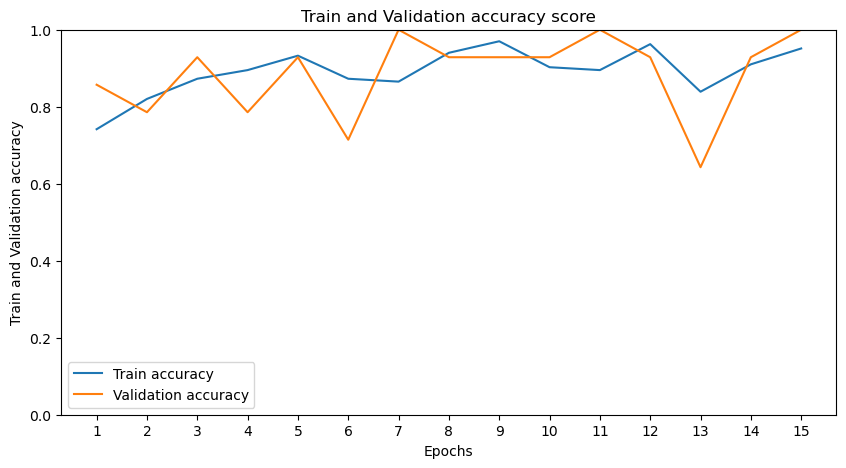

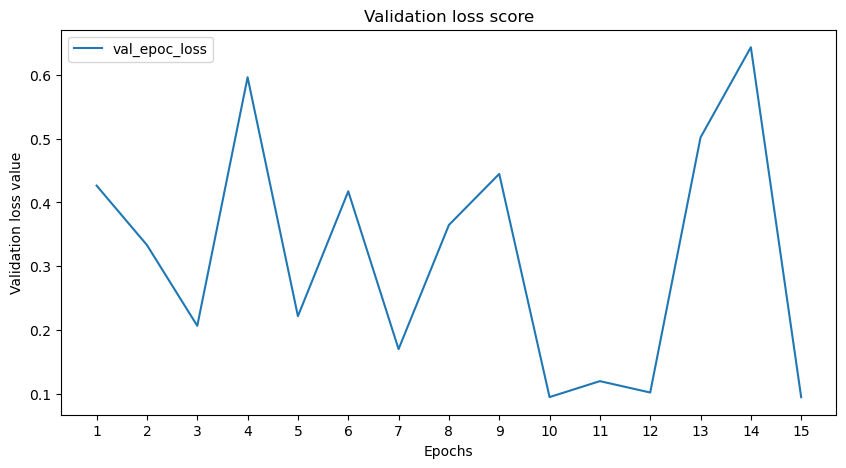

In [26]:
from matplotlib import pyplot as plt

class plot():
    def __init__(self, natija):
        
        plt.figure(figsize=(10, 5))
        plt.title("Train and Validation accuracy score")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation accuracy")
        plt.plot(natija["tr_acc_sc"], label = "Train accuracy")
        plt.plot(natija["val_acc_sc"], label = "Validation accuracy")
        plt.xticks(np.arange(len(natija['val_acc_sc'])), [i for i in range(1, len(natija['val_acc_sc']) + 1)])
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.title("Validation loss score")
        plt.ylabel("Validation loss value")
        plt.xlabel("Epochs")
        plt.plot(natija["val_epoc_loss"], label = "val_epoc_loss")
        plt.xticks(np.arange(len(natija['val_epoc_loss'])), [i for i in range(1, len(natija['val_epoc_loss']) + 1)])
        plt.legend()
        plt.show()
plot(result)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


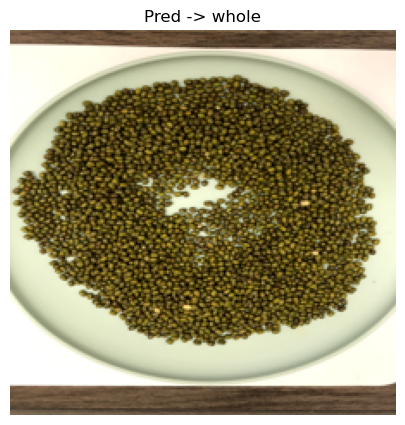

torch.Size([3, 224, 224])


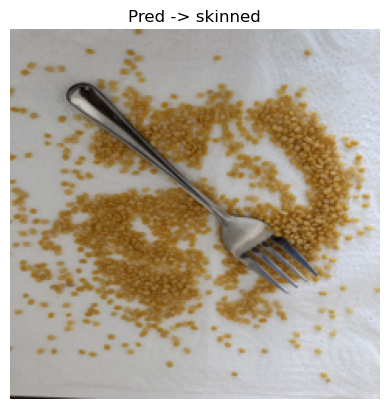

torch.Size([3, 224, 224])


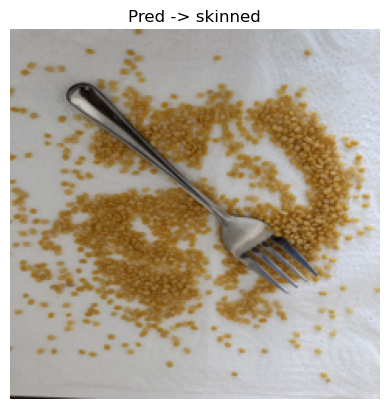

torch.Size([3, 224, 224])


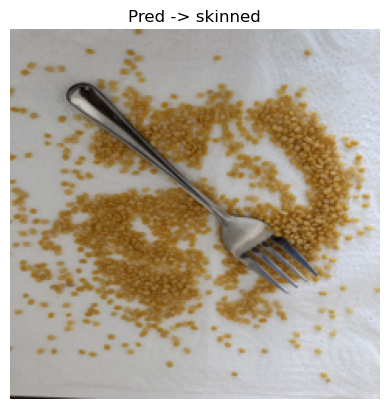

torch.Size([3, 224, 224])


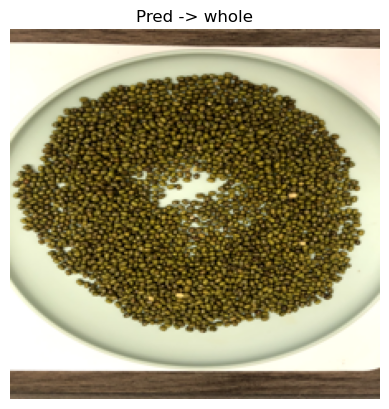

torch.Size([3, 224, 224])


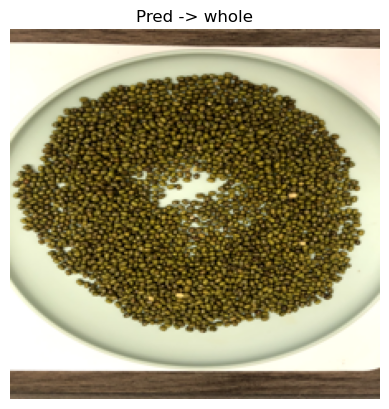

torch.Size([3, 224, 224])


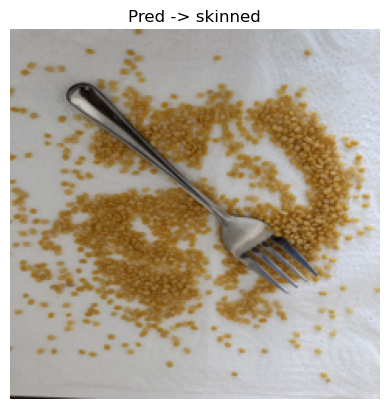

torch.Size([3, 224, 224])


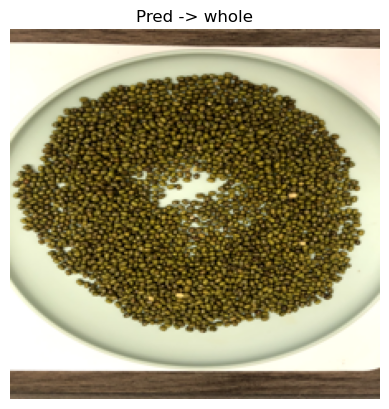

torch.Size([3, 224, 224])


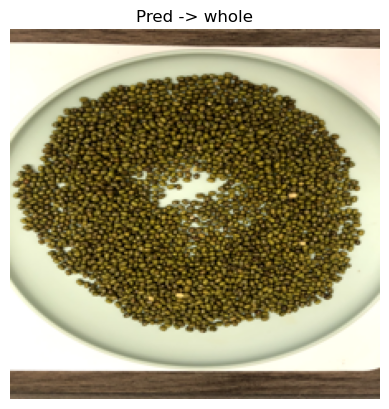

torch.Size([3, 224, 224])


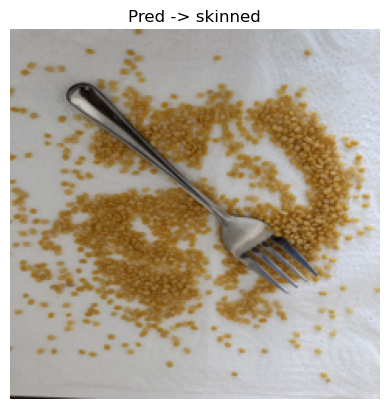

In [27]:
import random
def inference(data, rasmlar_soni, model, device, klass_nomi = None):
    bashoratlar = []
    rasmlar = []
    
    for idx, batch in enumerate(data):
        if idx == 10: break
        rasm, gt = batch
        print(type(rasm))
        rasm, gt = rasm.to(device), gt.to(device)
        bashorat = model(rasm)
        bashorat_cls = torch.argmax(bashorat, dim = 1)
        bashoratlar.append(bashorat_cls)
        rasmlar.append(rasm)
    
    plt.figure(figsize=(10, 5))
    indekslar = [random.randint(0, len(rasmlar)-1) for _ in range(rasmlar_soni)]
    
    for idx, indeks in enumerate(indekslar):
        rasm = rasmlar[indeks][3]
        print(rasm.shape)

        plt.imshow((rasm*255).cpu().permute(2,1,0).numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"Pred -> {klass_nomi[bashoratlar[indeks][3]]}")
        
            
        plt.show()

inference(data = test_dl, model = model.to(device), device = device, rasmlar_soni = 10, klass_nomi = list(klass_nomlari))
model = torch.load("best_model/lentils_best_model.pth")